https://developer.spotify.com/documentation/web-api/
https://developer.spotify.com/
https://developer.spotify.com/dashboard/login

**Objectives:**
- recommend the next song for an user base on his current playlist

**Assumptions:**
- tracks of a given playlist are the favorite songs of the user

**Methodology:**
1. Collaborative filtering
2. Initial sample for each user will take 70% of the tracks in the playlist (check if the sorting of the musics in the playlist has any information - date of inclusion, user sorting, etc) and then use the remaining 30% of the tracks as test.
3. **If we have time:** Hybrid model by adding *Content based filtering* for playlists with few tracks
    - Track features: genre, time, top_track, etc.
**Concerns:**
- cold start: playlists with few tracks
- rare tracks: treatment to be applied to the tracks with low frequency on the database
- only positive rating: we will have only tracks that the user liked, we do not have any data about tracks that they did not like.


**Python Libraries:**
- Sagemaker
- Elasticsearch
- PySpark

In [1]:
# Default libraries: pandas, numpy
# import beakerx
import cProfile
import collections
import datetime

import feather
import itertools
import math
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import urbangrammar_graphics as ugg

from IPython.display import Markdown as md
from collections import Counter
from clustergram import Clustergram
from datetime import datetime
from dotenv import load_dotenv
from itertools import groupby

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})

In [2]:
def single_list(my_list):
    single = []
    for e in my_list:
        single.extend(e)
    return single

def single_list_nested(my_list):
    single = []
    for e in my_list:
        for a in e:
            single.extend(a)
    return single

def sorted_list(xs):
    counts = collections.defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])

In [3]:
data_path = os.getcwd() + '\\data\\external\\raw_data.pkl'
df = pd.read_pickle(data_path)
print(df.info())

# total = 0
# idx = 0
# while total < 10000:
# #     print(len(df.iloc[idx, 2]))
    
#     total = total + len(df.iloc[idx, 2])
#     idx = idx + 1
# #     len(df.iloc[0:n, :])
# print(idx)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2450 non-null   object
 1   playlist_id  2450 non-null   object
 2   tracks_id    2450 non-null   object
 3   tracks       2450 non-null   object
 4   popularity   2450 non-null   object
 5   artists_id   2450 non-null   object
 6   artists      2450 non-null   object
 7   albums_id    2450 non-null   object
 8   albums       2450 non-null   object
dtypes: object(9)
memory usage: 172.4+ KB
None


In [48]:
# matrix track x track
idx = 100
df_test = df.iloc[0:idx, :]
# df_test = df

print(df_test.info())

s_tracks_id = single_list(df_test['tracks_id'])
data = {'tracks_id': s_tracks_id}
df_track = pd.DataFrame(data)

tracks_rank = df_track.groupby(['tracks_id']).agg(
    tracks_count=('tracks_id','count')
    )
tracks_rank = tracks_rank.sort_values('tracks_count',ascending=False)

# tracks_rank


# s_tracks_id = list(set(single_list(df_test['tracks_id'])))
# s_tracks_id = list(set(single_list(df['tracks_id'])))
s_tracks_id = list(tracks_rank.index)
# print(len(s_tracks_id))
# s_tracks = single_list(df_test['tracks'])

shape = [len(s_tracks_id),len(s_tracks_id)]
track_matrix = np.zeros(shape, dtype=int, order='C')

for i, row_track in enumerate(s_tracks_id):
    row = s_tracks_id.index(row_track)
    if i != row: print("i: " + str(i) + ": " + row_track), print()
    
    
    for playlist in df_test['tracks_id']:
        try:
            check = playlist.index(row_track)
        except ValueError:
#             print(row)
            check = -1
        if check >= 0:
            for col_track in playlist:
                if col_track is not None:
                    col = s_tracks_id.index(col_track)
#                     print(col_track  + " - " + str(col))
#                     tr = df_test['tracks'][n][col]
#                     print("track: " + str(n) + ": " + col_track + " - col_match:" + str(col) + ": ") # + tr)
                    track_matrix[row, col] += 1
# print(track_matrix)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      100 non-null    object
 1   playlist_id  100 non-null    object
 2   tracks_id    100 non-null    object
 3   tracks       100 non-null    object
 4   popularity   100 non-null    object
 5   artists_id   100 non-null    object
 6   artists      100 non-null    object
 7   albums_id    100 non-null    object
 8   albums       100 non-null    object
dtypes: object(9)
memory usage: 7.2+ KB
None


In [49]:
track_matrix

array([[15, 11, 11, ...,  0,  0,  0],
       [11, 15,  9, ...,  0,  0,  0],
       [11,  9, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  1,  0,  1]])

In [50]:
print(tracks_rank)
n_rows, n_cols = track_matrix.shape

for track in tracks_rank:
#     if i == 1:
        print(track)
#     if track_matrix[i][i] != track_matrix[i][i]:
#             print("Difference: " + str(i) + ", " + str(j))

                        tracks_count
tracks_id                           
10Igtw8bSDyyFs7KIsKngZ            15
2G7V7zsVDxg1yRsu7Ew9RJ            15
09IStsImFySgyp0pIQdqAc            15
58q2HKrzhC3ozto2nDdN4z            14
2xLMifQCjDGFmkHkpNLD9h            14
...                              ...
76JvOYjETbnJ5NynteH27v             1
2wTxJWt2gA9a1Z94dTnPiI             1
0GHwNr0lqf8jpc9wesmnHo             1
7mXKTWCKBpohAIgw25vTl5             1
7KmzW7UbwR6A55r41gm6Ql             1

[3006 rows x 1 columns]
tracks_count


In [51]:
n_rows, n_cols = track_matrix.shape
for i in range(0,n_rows):
    for j in range(i,n_cols):
        if track_matrix[i][j] != track_matrix[j][i]:
            print("Difference: " + str(i) + ", " + str(j))
# for i, in enumerate(track_matrix):
#     for j,col in enumerate(row):
#         if 

In [52]:
column_sums = track_matrix.sum(axis=0)
row_sums = track_matrix.sum(axis=1)

print(column_sums)
print(row_sums)

[1250 1190  990 ...   30   25   30]
[1250 1190  990 ...   30   25   30]


In [56]:
if len(row_sums) != len(column_sums):
    print("error row * col")

for i in range(0,len(row_sums)):
     if tracks_rank[i] != column_sums[i]:
            print("Difference: " + str(i) + "," + str(j))

KeyError: 0

In [57]:
# min_max = MinMaxScaler()
# tracks_rank['count_scaled'] = min_max.fit_transform(tracks_rank[["tracks_count"]])

track_normed_by_col = track_matrix / track_matrix.max(axis=0)
track_normed_by_row = track_matrix / track_matrix.max(axis=1)

delta = track_normed_by_col - track_normed_by_row
print(delta)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


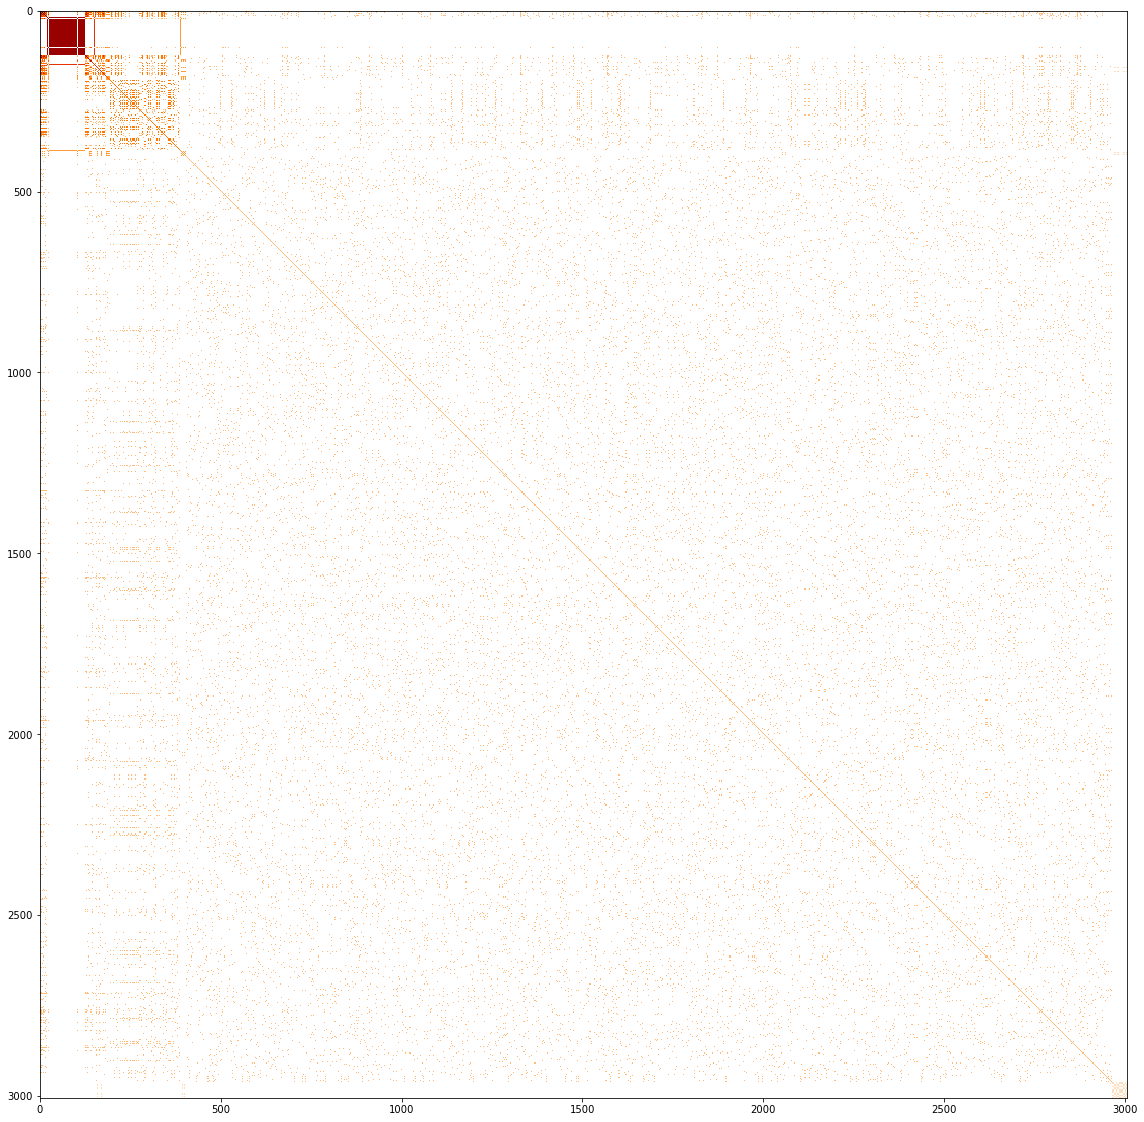

In [58]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(111)
plt.imshow(-track_matrix, interpolation='nearest', cmap=plt.cm.gist_heat)
ax.set_aspect('equal')
plt.show()

In [ ]:
load_dotenv()
SPOTIPY_API = os.getenv('SPOTIPY_API')
SPOTIPY_API_KEY = os.getenv('SPOTIPY_API_KEY')
scope=''

# https://spotipy.readthedocs.io/en/latest/#
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_API, client_secret=SPOTIPY_API_KEY)

# help(sp)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
def get_playlist_detail(user_id, playlist_id):
    l_artists = []
    l_albums = []
    l_tracks = []
    l_popularity = []
    l_artists_id = []
    l_albums_id = []
    l_tracks_id = []
    
    playlist = sp.user_playlist(user_id, playlist_id)
    
    for item in playlist['tracks']['items']:
        group = []
        group_id = []
        for artist in item['track']['album']['artists']:
            group.append(artist['name'])
            group_id.append(artist['id'])
        l_artists.append(group)
        l_artists_id.append(group_id)
        l_albums.append(item['track']['album']['name'])
        l_tracks.append(item['track']['name'])
        l_popularity.append(item['track']['popularity'])
        
        l_albums_id.append(item['track']['album']['id'])
        l_tracks_id.append(item['track']['id'])
        
    return user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id;

# user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id = get_playlist_detail('spotify', '37i9dQZF1DWXjlWxUbm84A')
# user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id

In [ ]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_1_uid_pid.pkl'
if os.path.exists(data_path):
    data_path_2 = os.getcwd() + '\\data\\external\\raw_2_playlists.pkl'
    if not(os.path.exists(data_path_2)):
        with open(data_path, 'rb') as f:
            uid_pid_raw = pickle.load(f)
else:
    n = 950 # max = 950
    p_limit = 50 # limit of playlists max = 50

    # list of all user ids (UID) and playlist ids (PID)
    uid_pid_raw = []
    
    for y in range(2018,2022,1):
        txt = 'year:' + str(y)
        for i in range(0,n,1):
            if i % 100 == 0: print(txt + ': ' + str(i) + '/' + str(n))
            uid_pid = sp.search(q=txt, type='playlist', limit=p_limit, offset=i) #,market='US'
            uid_pid_raw.append(uid_pid)
    # Save the data
    with open(data_path, 'wb') as f:
        pickle.dump(playlist_raw, f)


t_end = time.time()
np.abs(t_start - t_end)

In [ ]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_2_playlists.pkl'
if os.path.exists(data_path):
#     print("Loading data...")
#     data_path_2 = os.getcwd() + '\\data\\external\\split_1_playlists.pkl'
#     if not(os.path.exists(data_path_2)):
#         with open(data_path, 'rb') as f:
#             playlist_raw = pickle.load(f)
else:
    print("Requesting playlists - Spotipy")
#     playlist_raw = []

#     for i, result in enumerate(uid_pid_raw):
#         print(i)
#         if i % 100 == 0: print(i)
#         for user in result['playlists']['items']:
#             pid = user['id']
#             uid = user['owner']['id']
#             try:
#                 playlist = sp.user_playlist(user['id'],user['owner']['id'])
#                 playlist_raw.append(playlist)
#             except:
#                 print(uid + " " + pid)
                   
   # Save the data
#     with open(data_path, 'wb') as f:
#         pickle.dump(playlist_raw, f)

t_end = time.time()
np.abs(t_start - t_end)

In [ ]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_data.pkl'
if os.path.exists(data_path):
    df = pd.read_pickle(data_path)
else:
#     print('ops')
    n = 50
    p_limit = 50 # limit of playlists max = 50

    user_id = []
    playlist_id = []
    artists = []
    albums = []
    tracks = []
    popularity = []
    artists_id = []
    albums_id = []
    tracks_id = []

    for i in uid_pid:
        if i-1 % 100 == 0: print(i)
        for user in result['playlists']['items']:
            pid = user['id']
            uid = user['owner']['id']
#                 user_id.append(uid)
#                 playlist_id.append(pid)
            p_user_id, p_playlist_id, p_artists, p_albums, p_tracks, p_popularity, p_artists_id, p_albums_id, p_tracks_id = get_playlist_detail(uid,pid)

            user_id.append(p_user_id)
            playlist_id.append(p_playlist_id)
            artists.append(p_artists)
            albums.append(p_albums)
            tracks.append(p_tracks)
            popularity.append(p_popularity)
            artists_id.append(p_artists_id)
            albums_id.append(p_albums_id)
            tracks_id.append(p_tracks_id)
#             if i-1 % 100 == 0: print('tot:' + str(len(playlist_id)))

    # intialise data of lists.
    data = {
        'user_id': user_id,
        'playlist_id': playlist_id,
        'tracks_id': tracks_id,
        'tracks': tracks,
        'popularity': popularity,
        'artists_id': artists_id,
        'artists': artists,
        'albums_id': albums_id,
        'albums': albums
    }

    # Create DataFrame
    df = pd.DataFrame(data)
    df.head()

    # Save the data
    df.to_pickle(data_path)

t_end = time.time()
np.abs(t_start - t_end)

In [ ]:
s_tracks_id = single_list(df['tracks_id'])
s_tracks = single_list(df['tracks'])
s_popularity = single_list(df['popularity'])

s_artists = single_list_nested(df['artists'])
s_artists_id = single_list_nested(df['artists_id'])

s_albums = single_list(df['albums'])
s_albums_id = single_list(df['albums_id'])

data = {
    'tracks_id': s_tracks_id,
    'tracks': s_tracks,
    'popularity': s_popularity
}
df_track = pd.DataFrame(data)
# print(df_track.head())

data = {
    'artists_id': s_artists_id,
    'artists': s_artists
}
df_artist = pd.DataFrame(data)
# print(df_artist.head())


data = {
    'albums_id': s_albums_id,
    'albums': s_albums
}
df_album = pd.DataFrame(data)
# print(df_album.head())

In [ ]:
tracks_rank = df_track.groupby(['tracks_id','tracks']).agg(
    popularity=('popularity','max'),
    tracks_count=('tracks_id','count')
    )

min_max = MinMaxScaler()
tracks_rank['count_scaled'] = min_max.fit_transform(tracks_rank[["tracks_count"]])

tracks_rank["rank"] = tracks_rank['tracks_count'].rank(method='average',ascending=False)

tracks_rank = tracks_rank.sort_values('tracks_count',ascending=False)

tracks_rank

In [ ]:
album_rank = df_album.groupby(['albums_id','albums']).agg(album_count=('albums_id','count'))

min_max = MinMaxScaler()
album_rank['count_scaled'] = min_max.fit_transform(album_rank[["album_count"]])

album_rank["rank"] = album_rank['album_count'].rank(method='average',ascending=False)

album_rank = album_rank.sort_values('album_count',ascending=False)

album_rank

In [ ]:
df_artist.head
artist_rank = df_artist.groupby(['artists_id','artists']).agg(artist_count=('artists_id','count'))

min_max = MinMaxScaler()
artist_rank['count_scaled'] = min_max.fit_transform(artist_rank[["artist_count"]])

artist_rank["rank"] = artist_rank['artist_count'].rank(method='average',ascending=False)

artist_rank = artist_rank.sort_values('artist_count',ascending=False)

artist_rank

In [ ]:
# tracks_cartesian = []
# for element in itertools.product(s_tracks_id,s_tracks_id):
#     tracks_cartesian.append(element)

# https://stackoverflow.com/questions/11144513/cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points
# def cartesian_product(*arrays):
#     la = len(arrays)
#     dtype = np.result_type(*arrays)
#     arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
#     for i, a in enumerate(numpy.ix_(*arrays)):
#         arr[...,i] = a
#     return arr.reshape(-1, la)


# # tracks_cartesian = cartesian_product(*(s_tracks_id * 2))

In [ ]:
# for key, item in df_test.items():
#     print(key)
#     if key == 'tracks_id':
#         print(item)

In [ ]:
# # Define count_entries()
# def count_entries(csv_file,c_size,colname):
#     """Return a dictionary with counts of
#     occurrences as value for each key."""
    
#     # Initialize an empty dictionary: counts_dict
#     counts_dict = {}

#     # Iterate over the file chunk by chunk
#     for chunk in pd.read_csv(csv_file,chunksize=c_size):

#         # Iterate over the column in DataFrame
#         for entry in chunk[colname]:
#             if entry in counts_dict.keys():
#                 counts_dict[entry] += 1
#             else:
#                 counts_dict[entry] = 1

#     # Return counts_dict
#     return counts_dict

# # Call count_entries(): result_counts
# result_counts = count_entries('tweets.csv',10,'lang')

# # Print result_counts
# print(result_counts)


In [ ]:
from numba import jit, cuda
# from numba import cuda
import numpy as np
import code
# to measure exec time
from timeit import default_timer as timer
  
# normal function to run on cpu
def func(a):                                
    for i in range(10000000):
        a[i]+= 1

# function optimized to run on gpu 
cuda.jit(target ="cuda")                         
code.interact(local=locals)
def func2(a):
    for i in range(100000000):
        a[i]+= 1

if __name__=="__main__":
    n = 10000000                            
    a = np.ones(n, dtype = np.float64)
    b = np.ones(n, dtype = np.float32)
      
    start = timer()
    func(a)
    print("without GPU:", timer()-start)    
      
    start = timer()
    func2(a)
    print("with GPU:", timer()-start)

Python 3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)] on win32
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


In : 


TypeError: exec() globals must be a dict, not builtin_function_or_method


KeyboardInterrupt


In [4]:
from numba import jit, cuda
# from numba import cuda
import numpy as np
from timeit import default_timer as timer

@cuda.jit(device=True)
def mandel(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Mandelbrot
  set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel(real, imag, iters)

gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)

imshow(gimage)

LinkerError: [222] Call to cuLinkAddData results in UNKNOWN_CUDA_ERROR
ptxas application ptx input, line 9; fatal   : Unsupported .version 7.3; current version is '7.2'